In [1]:
from pathlib import Path
import pandas as pd
import woodsort.nwb as nwb 
import pynapple as nap
import spikeinterface.full as si
import warnings
import neuroconv.tools.spikeinterface as nc

In [2]:
### SPECIFY PATHS ### 

data_path = Path('/home/avadher/Data/')
session_name = 'H7113-250604'
meta_name = 'H7100_metadata.xlsx'
analyzer_name = session_name + '_analyzer_mountainsort5'
nwb_path = data_path / 'NWB' / session_name

session_path = list(data_path.rglob(session_name))[0]

# Ignore annoying warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
### LOAD DATA ###

metadata = nwb.io.read_metadata_excel(data_path / meta_name, session_name, print_output=True)
start_time = nwb.io.get_start_time(session_path)

# load tracking 
tracking = pd.read_csv(session_path / 'TrackingProcessed.csv',index_col=0, header=0)
pos = nap.TsdFrame(tracking[["x", "y"]])
hd = nap.Tsd(tracking['hd'])
epochs = pd.read_csv(session_path / 'EpochTimestamps.csv', header=0)

# get probe mapping
probe_mapping = pd.read_csv(session_path / 'ChannelMapping.csv',index_col=0, header=0)

# add probe 



{'epoch': {'1': 'wake', '2': 'sleep', '3': 'wake_cue_rot'},
 'file': {'experiment_description': 'Reorientation in the head-direction system',
          'experimenter': 'Narayanan, Trisha',
          'institution': 'University of Edinburgh',
          'lab': 'Wood/Dudchenko lab',
          'name': 'H7113-250604',
          'protocol': 'day1',
          'session_description': 'Cue rotations (45, 90, 135, 180 deg)'},
 'probe': [{'description': '2x32-channels, 25 um channel spacing, implanted at 10 deg angle. '
                           'Channels sorted top to bottom of shank.',
            'id': 1,
            'location': 'left postsubiculum',
            'nshanks': 2,
            'step': 25,
            'type': 'Cambridge Neurotech H7 probe'}],
 'subject': {'dob': 250228, 'genotype': 'WT', 'line': 'Fmr1', 'sex': 'M', 'stock_id': 1906344}}

Start time from sync_messages.txt: 2025-06-04 14:46:12.720000+01:00


In [4]:
### NWB ### 

#Create NWB file
nwbfile = nwb.convert.create_nwb_file(metadata, start_time)

# Add units
nwbfile = nwb.convert.add_units_spikeinterface(nwbfile, session_path / analyzer_name)

# Add tracking
nwbfile = nwb.convert.add_tracking(nwbfile, pos, hd)

# Add epochs
nwbfile = nwb.convert.add_epochs(nwbfile, epochs, metadata)

# Save NWB file
nwbfile = nwb.convert.save_nwb_file(nwbfile, nwb_path, session_name)

# Load to check
rec = nwb.convert.load_nwb_file(nwb_path, session_name)



Creating NWB file and adding metadata...
Adding SpikeInterface units and metrics to the NWB file...
(94, 60, 64)
Adding tracking to NWB file...
Adding epochs to NWB file...
Saving NWB file...
Created directory: /home/avadher/Data/NWB/H7113-250604
Done!
H7113-250604
┍━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys           │ Type        │
┝━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units          │ TsGroup     │
│ epochs         │ IntervalSet │
│ position       │ TsdFrame    │
│ head-direction │ Tsd         │
┕━━━━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙


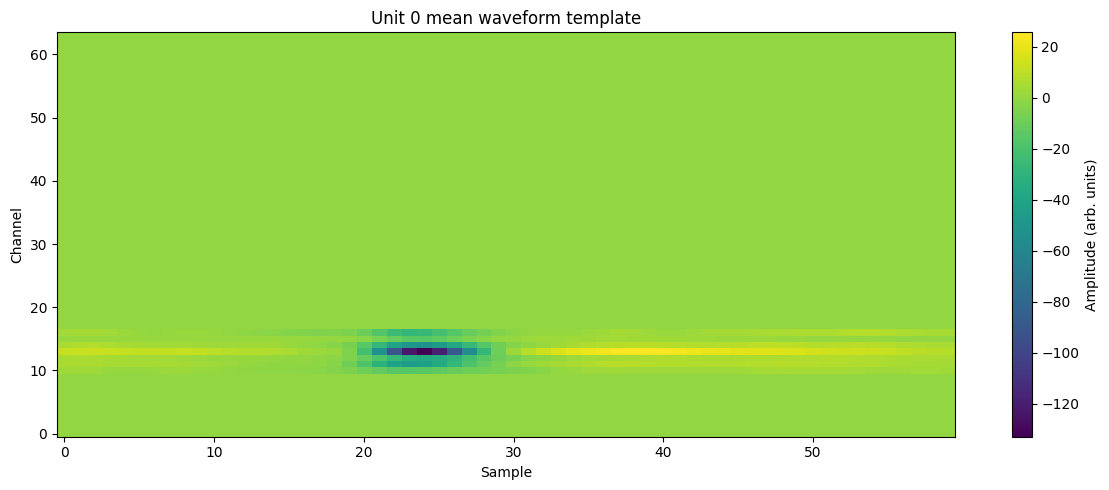

In [5]:

import numpy as np
import spikeinterface.full as si
from neuroconv.tools.spikeinterface import add_sorting_to_nwbfile, add_recording_metadata_to_nwbfile
import pandas as pd
import json
import matplotlib.pyplot as plt


wf = rec.nwb.units['waveform_mean'][1].T



import matplotlib.pyplot as plt

# Grab unit 0 template from NWB

plt.figure(figsize=(12, 5))
im = plt.imshow(wf, aspect="auto", origin="lower")
plt.ylabel("Channel")
plt.xlabel("Sample")
plt.title("Unit 0 mean waveform template")
plt.colorbar(im, label="Amplitude (arb. units)")
plt.tight_layout()
plt.show()
